## Project Overview

This project investigates the use of Singular Value Decomposition (SVD) for classification tasks in high-dimensional data. A truncated SVD representation is employed to construct low-rank linear subspace models for different classes.

Given a data matrix $A = U \Sigma V^\top$, its truncated approximation is defined as

$$
A_k = U_k \Sigma_k V_k^\top
= \sum_{i=1}^{k} \sigma_i u_i v_i^\top,
$$

where only the first $k$ singular values and corresponding singular vectors are retained. This low-rank representation captures the dominant structural information in the data while reducing dimensionality.

---

## SVD-based Classification of the MNIST Dataset

The proposed method is applied to the MNIST dataset, which consists of 70,000 grayscale images of handwritten digits (0–9), each of size $28 \times 28$. The dataset is divided into 60,000 training samples and 10,000 test samples.

Each digit class is modeled as a low-dimensional linear subspace learned from training data via truncated SVD. Classification of test images is performed by projecting them onto each class-specific subspace and assigning the label corresponding to the minimum projection residual.

The following sections introduce the dataset and visualize representative samples before constructing the class-wise SVD models.


Out of the 60,000 training images:
   5923  images belong to digit  0 , first five examples:


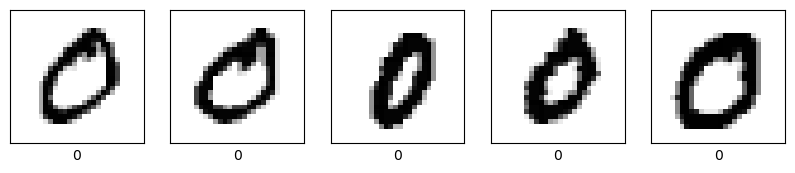

   6742  images belong to digit  1 , first five examples:


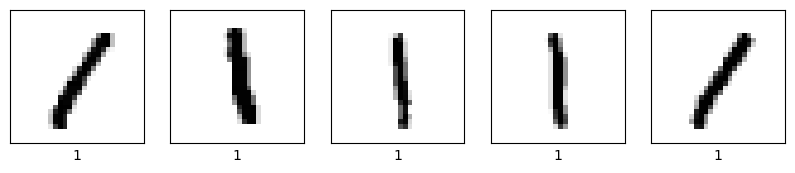

   5958  images belong to digit  2 , first five examples:


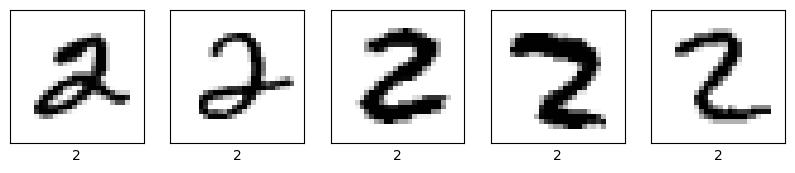

   6131  images belong to digit  3 , first five examples:


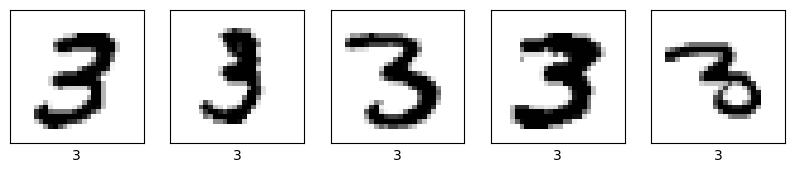

   5842  images belong to digit  4 , first five examples:


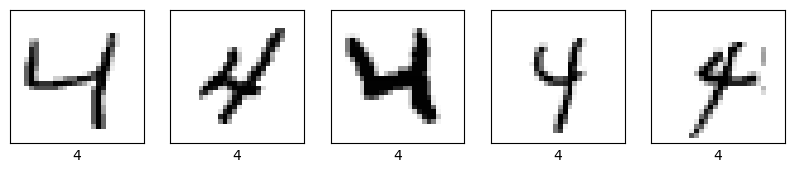

   5421  images belong to digit  5 , first five examples:


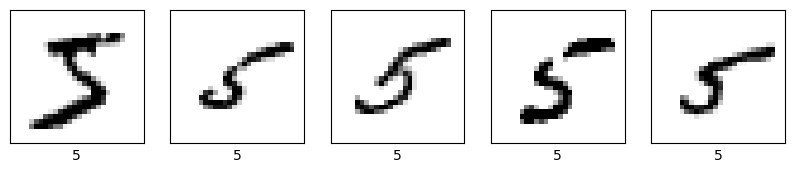

   5918  images belong to digit  6 , first five examples:


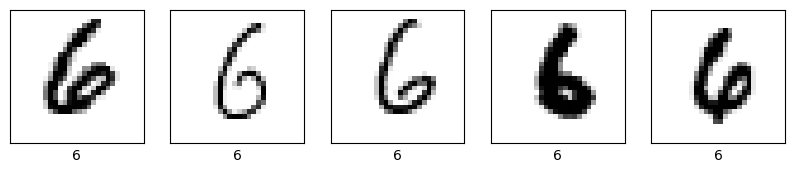

   6265  images belong to digit  7 , first five examples:


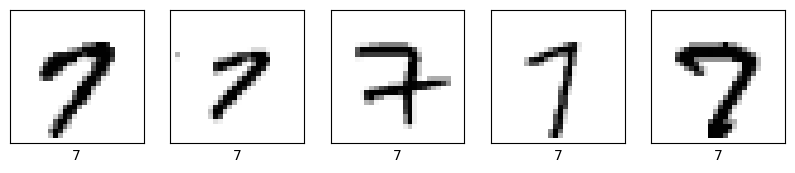

   5851  images belong to digit  8 , first five examples:


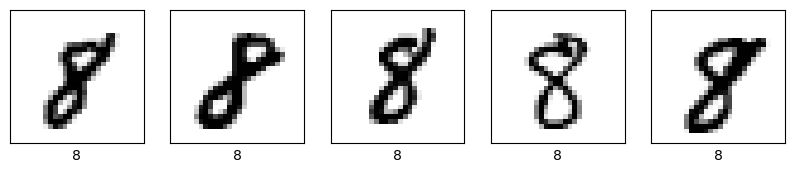

   5949  images belong to digit  9 , first five examples:


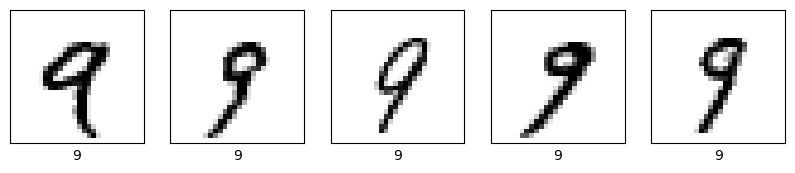

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mplt
np.random.seed(1234)

# load MNIST data set with 60,000 training images (28x28) of digits 0,1,...,9
# and 10,000 test images
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# normalize to range [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# helper function to display images
# idxs is array of indices for images and labels input parameter
# images is array of dimension (number_of_images,num_rows,num_columns)
# labels is array of dimension (number_of_images)
def show_img(idxs, images, labels):
    num_cols = 5
    num_rows = int(np.ceil(np.array(idxs).size/5))
    plt.figure(figsize=(2*num_cols, 2*num_rows))
    for i, idx in enumerate(idxs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx], cmap=plt.cm.binary)
        plt.xlabel(labels[idx])
    plt.tight_layout
    plt.show()

print('Out of the 60,000 training images:')

for cur_digit in range(10):
    indices_d = np.argwhere(train_labels == cur_digit)[:,0]
    print('  ', indices_d.size,' images belong to digit ', cur_digit, ', first five examples:')
    show_img(indices_d[0:5], train_images, train_labels)

 The first 10 entries of the training data:


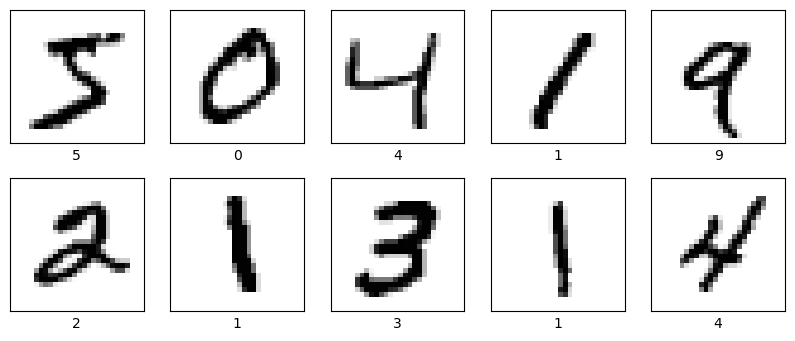

In [ ]:
# the first 10 entries of the training data
print(' The first 10 entries of the training data:')
show_img(range(10), train_images, train_labels)

## Class-wise SVD Representation of Digits

To model the variability of handwritten digits, a class-wise low-rank representation is constructed using truncated Singular Value Decomposition (SVD).

For each digit $d \in \{0,1,\ldots,9\}$, a subset of $m$ training images is selected (with $m = 1000$). Each image is vectorized into $\mathbb{R}^{784}$ and the resulting vectors are assembled into a data matrix $A^{(d)} \in \mathbb{R}^{784 \times m}$, where each column corresponds to a flattened image of digit $d$.

A truncated SVD with rank $k = 20$ is then computed for each class-specific matrix, yielding a low-dimensional subspace representation of the corresponding digit class. The leading and trailing singular vectors of each truncated basis are visualized by reshaping them into images of size $28 \times 28$. These visualizations provide insight into the dominant and less significant structural patterns learned for each digit.


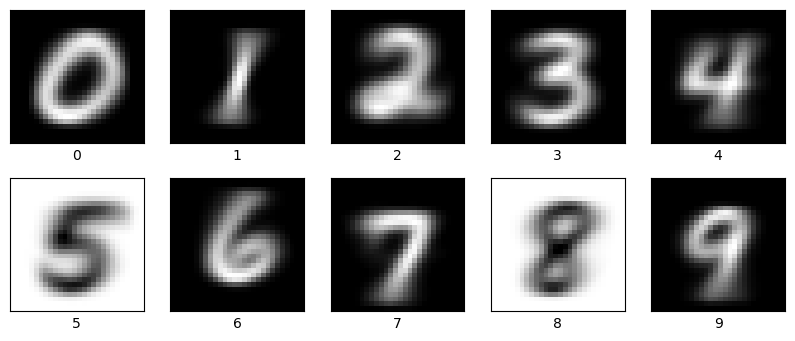

In [24]:
m = 1000
k = 20

num_pixels = train_images[0].size

A = []

for d in range(10):
    indices_d = np.argwhere(train_labels == d)
    perm = np.random.permutation(indices_d.size)
    aux = train_images[indices_d[perm[:m]], :, :]
    A_d = aux.reshape((m, num_pixels))
    A.append(A_d.T)

from scipy.sparse.linalg import svds

U = []
Sigma = []
V = []

for d in range(10):
    U_d, Sigma_d, V_d = svds(A[d], k=k)
    U.append(U_d)
    Sigma.append(Sigma_d)
    V.append(V_d)

imgs = np.array(np.empty((10, 28, 28)))
for d in range(10):
    imgs[d, :, :] = np.reshape(U[d][:, -1], (28, 28))

show_img(range(10), imgs, range(10))

## Classification via Subspace Projections

The class-specific truncated SVD bases $U_k^{(d)} \in \mathbb{R}^{784 \times k}$ are used to perform digit classification using a subspace projection approach.

Given a test image represented as a vector in $\mathbb{R}^{784}$, its distance to each digit class is computed by projecting it onto the corresponding subspace and evaluating the resulting projection residual. The image is assigned to the class for which this residual is minimized.

The performance of the proposed classification method is evaluated by computing the overall prediction accuracy on the MNIST test set. This approach achieves high accuracy, demonstrating the effectiveness of low-rank subspace representations for handwritten digit classification.


In [29]:
# array of dimension (m, 10), each entry contains the residual
prediction_residuals = np.zeros((test_images.shape[0],10))

# array of dim (m) with predicted digit
prediction_labels = np.zeros(test_images.shape[0], dtype='int')

for j in range(test_images.shape[0]):
    z = test_images[j].reshape((784, 1))
    for d in range(10):
        prediction_residuals[j,d] = np.linalg.norm(z - U[d] @ (U[d].T @ z))
    prediction_labels[j] = np.argmin(prediction_residuals[j])

print('Accuracy', np.count_nonzero(prediction_labels == test_labels) / test_images.shape[0])

Accuracy 0.9544


After having computed the `prediction_residuals` and `prediction_labels` arrays, we can execute the following code for some visualization.

First  10  images with classification results and residuals:


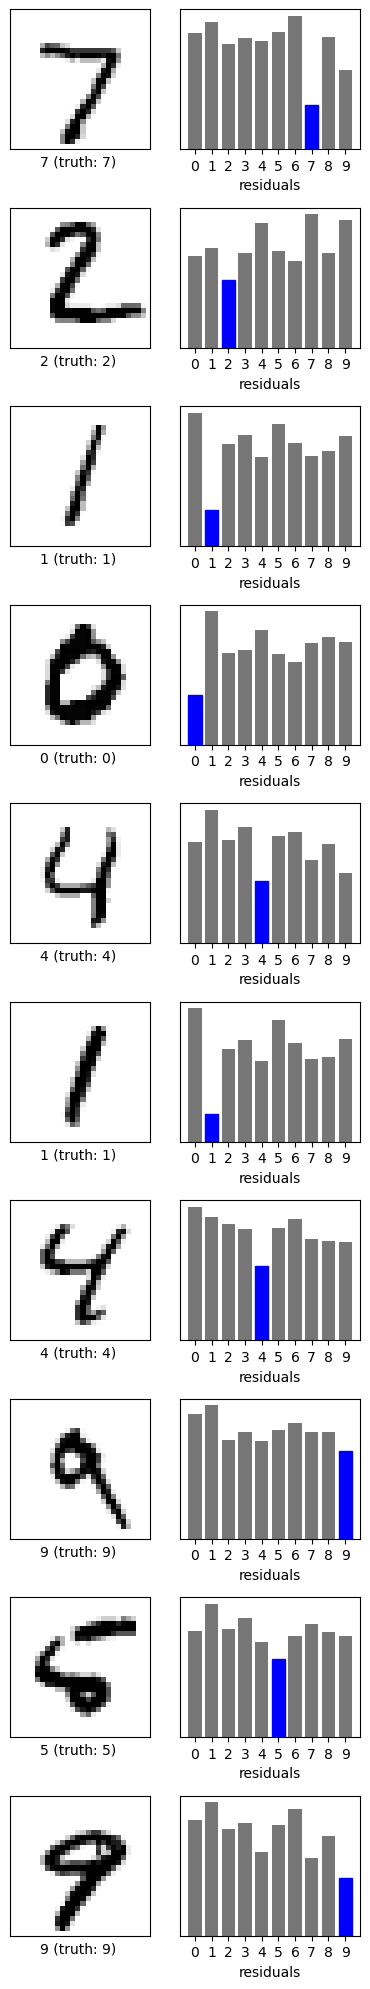

In [30]:
def plot_image_argmin(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmin(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} (truth: {}) ".format(predicted_label,
                                true_label,
                                color=color))

def plot_value_array_argmin(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    plt.xlabel('residuals')
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    predicted_label = np.argmin(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_first_images_argmin(num_rows, prediction_residuals, test_labels, test_images):
    num_cols = 1
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image_argmin(i, prediction_residuals[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array_argmin(i, prediction_residuals[i], test_labels)
    plt.tight_layout()
    plt.show()

# Plot first N images with classification results and residuals
N = 10
print('First ', N, ' images with classification results and residuals:')
plot_first_images_argmin(N, prediction_residuals, test_labels, test_images)

First  10  images with failed classification results and residuals:


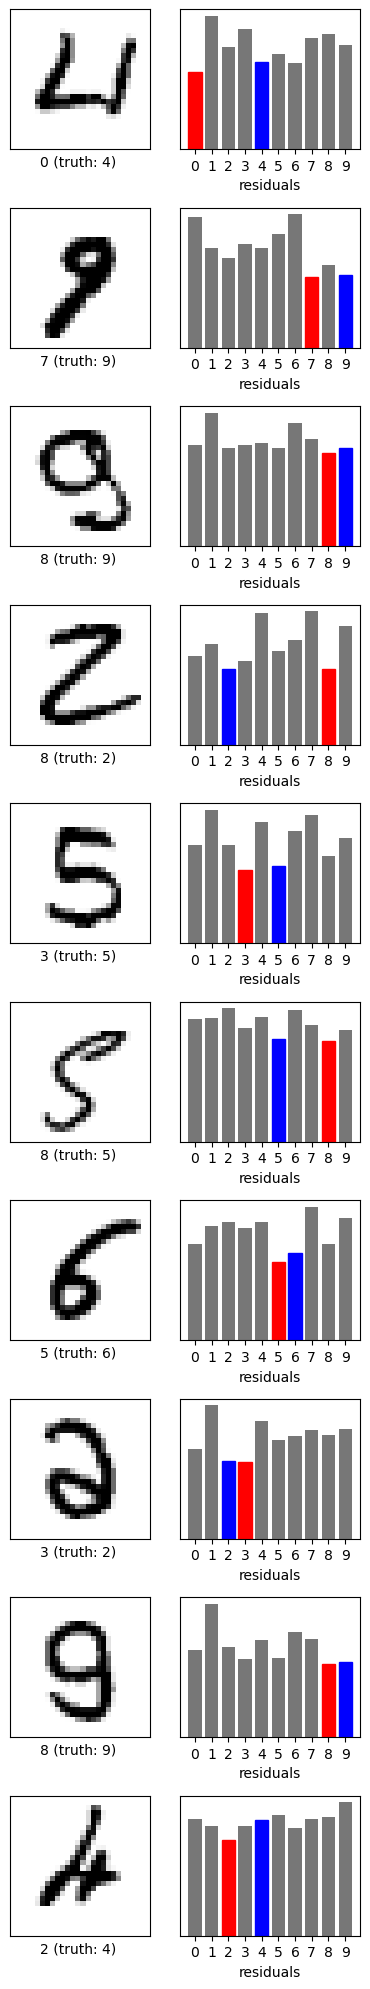

In [31]:
def plot_first_failures(num_rows, prediction_labels, test_labels, prediction_residuals, test_images):
    failed_indices = np.where(prediction_labels != test_labels)[0]
    num_cols = 1
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,failed_indices.size)):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image_argmin(failed_indices[i], prediction_residuals[failed_indices[i]], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array_argmin(failed_indices[i], prediction_residuals[failed_indices[i]], test_labels)
    plt.tight_layout()
    plt.show()

# Plot images for first N failed classification results
N = 10
print('First ', N, ' images with failed classification results and residuals:')
plot_first_failures(N, prediction_labels, test_labels, prediction_residuals, test_images)